# Data Analysis with Python

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mjsmagalhaes/examples-datascience/blob/main/course_ibm_data_analysis.ipynb)

Created as part of the corse _Data Analysis with Python_ from IBM @ Coursera.


In [1]:
%load_ext autoreload
%autoreload 2

# Colab
# !git clone https://github.com/mjsmagalhaes/examples-datascience.git repo
# %cd repo
# %pip install -r _requirements/dslib.txt

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go

from plotly.subplots import make_subplots

from icecream import ic
from scipy import stats
from rich.console import Console
from rich.table import Table

from sklearn.model_selection import cross_validate, KFold
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline

from dslib.missing import list_missing_values
from dslib.plots import plot
from dsexamples.imports85 import data as df

## Importing Data


This database comes with 2 files: imports-85.data and imports-85.names. 

The former contains the data itself while the latter the description of data. From that description I've created imports-85.headers with column names to create the csv file with the usual header. But all the work to tidy it was already done by dsdata and we can just use df imported above.

In [6]:
# import pandasgui as pdg
# pdg.show(df)

In [7]:
# remove first column (a duplicated index)
df.drop(columns=df.columns[0], axis='columns', inplace=True)


### Missing Values


In [8]:
list_missing_values(df)

normalized-losses: 41 missing values of type object
num-of-doors: 2 missing values of type object
bore: 4 missing values of type object
stroke: 4 missing values of type object
horsepower: 2 missing values of type object
peak-rpm: 2 missing values of type object
price: 4 missing values of type object


#### Replace Missing Data with the Average


In [9]:
def replace_nan_by_mean(column):
    """
    Replace NAs with the mean of the column over the entire dataset.
    """
    avg_col = column.astype("float").mean(axis=0)
    print("Average of {0}:".format(column.name), avg_col)
    return column.replace(np.nan, avg_col, inplace=True)

replace_nan_by_mean(df["normalized-losses"])
replace_nan_by_mean(df["stroke"])
replace_nan_by_mean(df["bore"])
replace_nan_by_mean(df["horsepower"])
replace_nan_by_mean(df["peak-rpm"])

Average of normalized-losses: 122.0
Average of stroke: 3.255422885572139
Average of bore: 3.3297512437810943
Average of horsepower: 104.25615763546799
Average of peak-rpm: 5125.369458128079


#### Replace Missing Data with the Most Frequent


In [10]:
def replace_nan_by_frequency(column):
    """
    Replace NAs with the mean of the column over the entire dataset.
    """
    mode_col = column.value_counts().idxmax()
    # print("Most Frequent Value of {0}:".format(column.name), mode_col)

    column.replace(np.nan, mode_col, inplace=True)
    return column

replace_nan_by_frequency(df['num-of-doors'])


0       two
1       two
2       two
3      four
4      four
       ... 
200    four
201    four
202    four
203    four
204    four
Name: num-of-doors, Length: 205, dtype: object

#### "Handling" Missing Values by Droping the line


In [11]:
df.dropna(subset=['price'], axis=0, inplace=True)

### Convert Types and Format


In [12]:
to_float = ["bore", "stroke", "price", "peak-rpm"]
df[to_float] = df[to_float].astype("float")

to_int = ["normalized-losses", 'horsepower']
df[to_int] = df[to_int].astype("int")
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 201 entries, 0 to 204
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   symboling          201 non-null    int32  
 1   normalized-losses  201 non-null    int32  
 2   make               201 non-null    object 
 3   fuel-type          201 non-null    object 
 4   aspiration         201 non-null    object 
 5   num-of-doors       201 non-null    object 
 6   body-style         201 non-null    object 
 7   drive-wheels       201 non-null    object 
 8   engine-location    201 non-null    object 
 9   wheel-base         201 non-null    float64
 10  length             201 non-null    float64
 11  width              201 non-null    float64
 12  height             201 non-null    float64
 13  curb-weight        201 non-null    int32  
 14  engine-type        201 non-null    object 
 15  num-of-cylinders   201 non-null    object 
 16  engine-size        201 non

In [13]:
df['fuel-type'].value_counts()
d = pd.get_dummies(df['fuel-type'])

d.rename(
    columns={'gas': 'fuel-type-gas', 'diesel': 'fuel-type-diesel'},
    inplace=True
)

# merge the new dataframe to the original dataframe
pd.concat([df, d], axis=1).drop('fuel-type', axis=1)

,symboling,normalized-losses,make,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,...,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price,fuel-type-diesel,fuel-type-gas
0,3,122,alfa-romero,std,two,convertible,rwd,front,88.6,168.8,...,3.47,2.68,9.0,111,5000.0,21,27,13495.0,0,1
1,3,122,alfa-romero,std,two,convertible,rwd,front,88.6,168.8,...,3.47,2.68,9.0,111,5000.0,21,27,16500.0,0,1
2,1,122,alfa-romero,std,two,hatchback,rwd,front,94.5,171.2,...,2.68,3.47,9.0,154,5000.0,19,26,16500.0,0,1
3,2,164,audi,std,four,sedan,fwd,front,99.8,176.6,...,3.19,3.40,10.0,102,5500.0,24,30,13950.0,0,1
4,2,164,audi,std,four,sedan,4wd,front,99.4,176.6,...,3.19,3.40,8.0,115,5500.0,18,22,17450.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,-1,95,volvo,std,four,sedan,rwd,front,109.1,188.8,...,3.78,3.15,9.5,114,5400.0,23,28,16845.0,0,1
201,-1,95,volvo,turbo,four,sedan,rwd,front,109.1,188.8,...,3.78,3.15,8.7,160,5300.0,19,25,19045.0,0,1
202,-1,95,volvo,std,four,sedan,rwd,front,109.1,188.8,...,3.58,2.87,8.8,134,5500.0,18,23,21485.0,0,1
203,-1,95,volvo,turbo,four,sedan,rwd,front,109.1,188.8,...,3.01,3.40,23.0,106,4800.0,26,27,22470.0,1,0


<AxesSubplot:xlabel='num-of-doors', ylabel='price'>

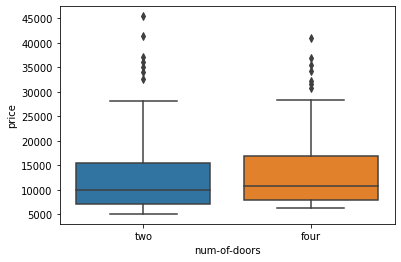

In [14]:
sns.boxplot(y="price", x='num-of-doors', data=df)

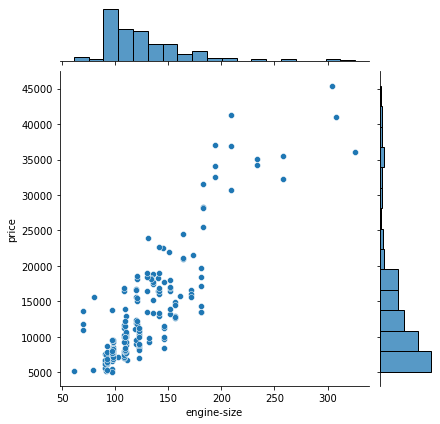

In [15]:
sns.jointplot(x='engine-size', y='price', data=df)

In [16]:
df[['price', 'drive-wheels', 'body-style']].groupby(
    ['drive-wheels', 'body-style'], 
    as_index=False
).mean().pivot(
    index='drive-wheels',
    columns='body-style'
)

price                                            \
body-style   convertible       hardtop     hatchback         sedan   
drive-wheels                                                         
4wd                  NaN           NaN   7603.000000  12647.333333   
fwd              11595.0   8249.000000   8396.387755   9811.800000   
rwd              23949.6  24202.714286  14337.777778  21711.833333   

                            
body-style           wagon  
drive-wheels                
4wd            9095.750000  
fwd            9997.333333  
rwd           16994.222222

In [17]:
plot().corr_heatmap(df)

alt.LayerChart(...)

Text(0.5, 1.0, 'Residual Plot')

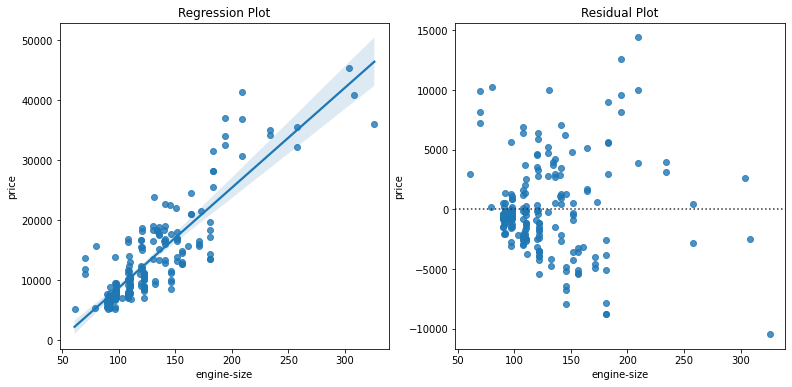

In [18]:
plt.figure(figsize=(13, 6))

plt.subplot(1, 2, 1)
sns.regplot(x="engine-size", y="price", data=df)
plt.title('Regression Plot')

plt.subplot(1, 2, 2)
sns.residplot(x="engine-size", y="price", data=df)
plt.title('Residual Plot')
# plt.ylim(0,);

In [19]:
df.describe(include=['object'])

,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,engine-type,num-of-cylinders,fuel-system
count,201,201,201,201,201,201,201,201,201,201
unique,22,2,2,2,5,3,2,6,7,8
top,toyota,gas,std,four,sedan,fwd,front,ohc,four,mpfi
freq,32,181,165,115,94,118,198,145,157,92


In [20]:
# engine-location as variable
engine_loc_counts = df['engine-location'].value_counts().to_frame()
engine_loc_counts.rename(
    columns={'engine-location': 'value_counts'}, 
    inplace=True
)
engine_loc_counts.index.name = 'engine-location'
engine_loc_counts.head(10)

,value_counts
engine-location,
front,198
rear,3


In [21]:
def list_relevant_vars(df) -> list:
    catVars = []
    numVars = []

    table = Table(
        title='Pearson Correlation + Anova',
        caption='Selected vars highlighted (numeric: green, categorical: blue).'
    )
    table.add_column('Variable', justify='center')
    table.add_column('R')
    table.add_column('P')

    for c in df:
        if c == 'price':
            continue

        numeric = df[c].dtype != 'object'

        if numeric:
            pearson_coef, p_value = stats.pearsonr(df[c], df['price'])
            msg = 'R={1:.3f} (p:{2:.2g})'.format(c, pearson_coef, p_value)
            color = 'pale_green3'

        else:
            grp = df[[c, 'price']].groupby([c])
            v = list(map(lambda k: grp.get_group(k)['price'], grp.groups))
            r = stats.f_oneway(*v)
            pearson_coef, p_value = r
            msg = 'F={1:.3f} (p:{2:.2g})'.format(c, r.statistic, r.pvalue)
            color = 'turquoise2'

        if p_value < 0.001:
            if numeric:
                numVars.append(c)
            else:
                catVars.append(c)
        else:
            color = None

        table.add_row(
            c,
            '{0:.3f}'.format(pearson_coef),
            '{0:.2g}'.format(p_value),
            style=color
        )

    Console().print(table)
    # Console().print(var_list)
    return numVars, catVars

nVar, cVar = list_relevant_vars(df)

      Pearson Correlation + Anova       
┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┓
┃     Variable      ┃ R      ┃ P       ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━┩
│     symboling     │ -0.082 │ 0.24    │
│ normalized-losses │ 0.134  │ 0.058   │
│       make        │ 33.232 │ 1.1e-50 │
│     fuel-type     │ 2.452  │ 0.12    │
│    aspiration     │ 6.631  │ 0.011   │
│   num-of-doors    │ 0.359  │ 0.55    │
│    body-style     │ 9.129  │ 8.8e-07 │
│   drive-wheels    │ 67.954 │ 3.4e-23 │
│  engine-location  │ 24.496 │ 1.6e-06 │
│    wheel-base     │ 0.585  │ 8.1e-20 │
│      length       │ 0.691  │ 8e-30   │
│       width       │ 0.751  │ 9.2e-38 │
│      height       │ 0.135  │ 0.055   │
│    curb-weight    │ 0.834  │ 2.2e-53 │
│    engine-type    │ 9.845  │ 2.1e-08 │
│ num-of-cylinders  │ 54.944 │ 2.9e-39 │
│    engine-size    │ 0.872  │ 9.3e-64 │
│    fuel-system    │ 15.024 │ 1.3e-15 │
│       bore        │ 0.543  │ 8e-17   │
│      stroke       │ 0.082  │ 0.25    │
│ compression-ratio │ 0.071  │ 0.32    │
│    horsepower     │ 0.810  │ 6.3e-48 │
│     peak-rpm      │ -0.102 │ 0.15    │
│     city-mpg      │ -0.687 │ 2.3e-29 │
│    highway-mpg    │ -0.705 │ 1.7e-31 │
└───────────────────┴────────┴─────────┘
  Selected vars highlighted (numeric:   
       green, categorical: blue).       

In [22]:
df.rename(columns={'drive-wheels': 'drive_wheels'}, inplace=True)

In [23]:
from itertools import combinations
c = 'make'
grp = df[[c, 'price']].groupby([c])
pairwise = list(combinations(grp.groups, 2))
result = map(
    lambda p: [
        p[0],
        p[1],
        stats.f_oneway(
            grp.get_group(p[0])['price'],
            grp.get_group(p[1])['price']
        ).pvalue],
    pairwise
)

r = pd.DataFrame(result).pivot(
    index=1,
    columns=0
).style.format('{:.2g}', na_rep='---').applymap(lambda x: 'color: royalblue;' if x < 0.001 and x > 0 else None)
r
# sns.heatmap(r)

# for pair in pairwise:
#   # v = list(map(lambda k: grp.get_group(k)['price'], grp.groups))
#   r = stats.f_oneway(grp.get_group(pair[0])['price'], grp.get_group(pair[1])['price'])
#   color = 'green' if r.pvalue < 0.001 else 'white'
#   print(style(
#     '{0:25s}: F={1:.3f} (p:{2:.2g})'.format('{0}+{1}'.format(*pair), r.statistic, r.pvalue),
#     fg=color
#   ))


In [24]:
# PolynomialFeatures()
x = df[nVar]
y = df['price']
cv = 5
fold = KFold(cv)

lr = LinearRegression()
res = cross_validate(lr, x, y, cv = fold, scoring=('r2'), return_estimator=True)

# lr.fit(df[nVar], df['price'])
# print('score:', lr.score(df[nVar], df['price']))
# yPred = lr.predict(df[nVar])

# tuple(zip(nVar, ))


In [ ]:
# list(zip(*res.values()))

In [25]:
t = Table()
for v in nVar:
    t.add_column(v, min_width=10, justify='center')
t.add_column('score', style='turquoise2', header_style='turquoise2 bold')

i = 0

for e in res['estimator']:
    t.add_row(
        *map(lambda c: '{0:.2f}'.format(c), e.coef_),
        '{0:.2f}'.format(res['test_score'][i])
    )
    i += 1

t

┏━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ wheel-base ┃   length   ┃   width    ┃ curb-weig… ┃ engine-si… ┃    bore    ┃ horsepower ┃  city-mpg  ┃ highway-m… ┃ score ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│   77.04    │  -147.28   │  1097.25   │    3.81    │   71.45    │  -510.81   │   47.39    │  -148.58   │   150.25   │ 0.75  │
│   89.06    │   10.84    │   269.62   │    1.77    │   59.95    │  -864.03   │   96.88    │  -121.40   │   226.17   │ 0.85  │
│   64.69    │  -120.85   │   628.34   │    6.27    │   71.32    │  -1169.91  │   59.85    │  -279.39   │   291.33   │ 0.10  │
│   170.52   │   -81.01   │   774.60   │    3.43    │   85.50    │  -2741.19  │   16.08    │  -115.73   │   28.83    │ 0.61  │
│   200.00   │   -35.98   │   422.37   │    1.15    │   81.05    │  -382.60   │   82.97    │  -118.95   │   160.34   │ 0.28  │
└────────────┴────────────┴────────────┴────────────┴────────────┴────────────┴────────────┴────────────┴────────────┴───────┘

In [25]:
fig = make_subplots(rows=5, cols=1, shared_xaxes=True, shared_yaxes=True)

i = 0
for f in fold.split(x, y):
    preditor = res['estimator'][i]

    xFold = x.iloc[f[1]]
    yFold = y.iloc[f[1]]
    yPred = preditor.predict(xFold)

    # plt.subplot(cv, 2, i*2 + 1);
    # sns.scatterplot(data=(yPred-yFold));
    # plt.title('Resid');

    # plt.subplot(cv, 2, i*2 + 2);
    # sns.kdeplot(data=xFold, color='blue')
    # sns.kdeplot(yPred, color='red');
    # plt.title('Densities');
    # plt.legend(['Price','Preditor']);

    plot_data = ff.create_distplot([yPred, yFold], ['Preditor', 'Fold'], show_hist=False).data
    for d in plot_data:
        fig.add_trace(d, row=i+1, col=1)
    

    i += 1

fig.update_layout(
    autosize=True,
    # width=500,
    height=1000,
    # margin=dict(
    #     l=50,
    #     r=50,
    #     b=100,
    #     t=100,
    #     pad=4
    # ),
    paper_bgcolor="LightSteelBlue",
)

fig.show()